# Bayes最適化　コード作成デモ<BR>
<div style="text-align: right;">
Nov. 2022<BR>
Masanobu NAKAYAMA<BR>
</div>


In [3]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


■ データの定義・入力 (Numpy形式)

[0.35243878 0.6968924  0.04598922 0.81188661 0.59208324 0.80183309
 0.70652208 0.88731074] 
 [ 3.91037735 -0.72101721  1.36775299 -0.15092817 -0.32060918 -0.92732187
 -0.63886297  0.52296188]


numpy.ndarray

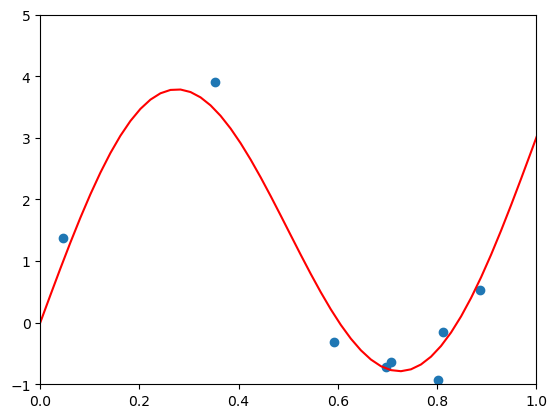

In [10]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = np.random.rand(8)
rdm_y=np.random.rand(8)-0.5
# True function is sin(2*pi*x) with Gaussian noise
train_y = 3*np.sin(train_x * (2 * math.pi)) + 3*train_x + rdm_y

true_x=np.linspace(0,2,100)
true_y = 3*np.sin(true_x * (2 * math.pi)) +3*true_x

plt.xlim([0,1])
plt.ylim([-1,5])
plt.plot(true_x,true_y,linestyle='solid',color='red')
plt.scatter(train_x,train_y)

print (train_x,"\n",train_y)
type(train_x)


In [11]:
train_nx=train_x.reshape(-1,1)
train_ny=train_y.reshape(-1,1)

print(train_nx)
print(train_ny)
type(train_nx)

[[0.35243878]
 [0.6968924 ]
 [0.04598922]
 [0.81188661]
 [0.59208324]
 [0.80183309]
 [0.70652208]
 [0.88731074]]
[[ 3.91037735]
 [-0.72101721]
 [ 1.36775299]
 [-0.15092817]
 [-0.32060918]
 [-0.92732187]
 [-0.63886297]
 [ 0.52296188]]


numpy.ndarray

■　ガウス過程の実行

In [12]:
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [92]:
kk=gp.kernels.ConstantKernel()*gp.kernels.RBF() + gp.kernels.WhiteKernel()
#kk=gp.kernels.RBF(length_scale=2) 
#kk=gp.kernels.Matern(nu=5)
#kk=gp.kernels.Matern(nu=5) + gp.kernels.WhiteKernel()

gpm = gp.GaussianProcessRegressor(kernel=kk,alpha=0.1, n_restarts_optimizer=30, normalize_y=True)
gpm.fit(train_nx, train_ny) 
print(gpm.log_marginal_likelihood())

#print ("theta0",gpm.kernel.theta)
#print ("theta1",gpm.kernel_.theta)
#print(gpm.kernel.bounds)


-8.336693315581895


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [93]:
newx = np.linspace(0,2,100).reshape(100,-1)
GPf, GPv = gpm.predict(newx, return_cov=True)  # 予測値と分散共分散行列
GPsd = np.sqrt(np.diag(GPv)).reshape(-1,1)                   # 予測値の標準偏差
#GPsd = np.sqrt(GPv)                   # 予測値の標準偏差



gpm.kernel.theta [0. 0. 0.]
gpm.kernel 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


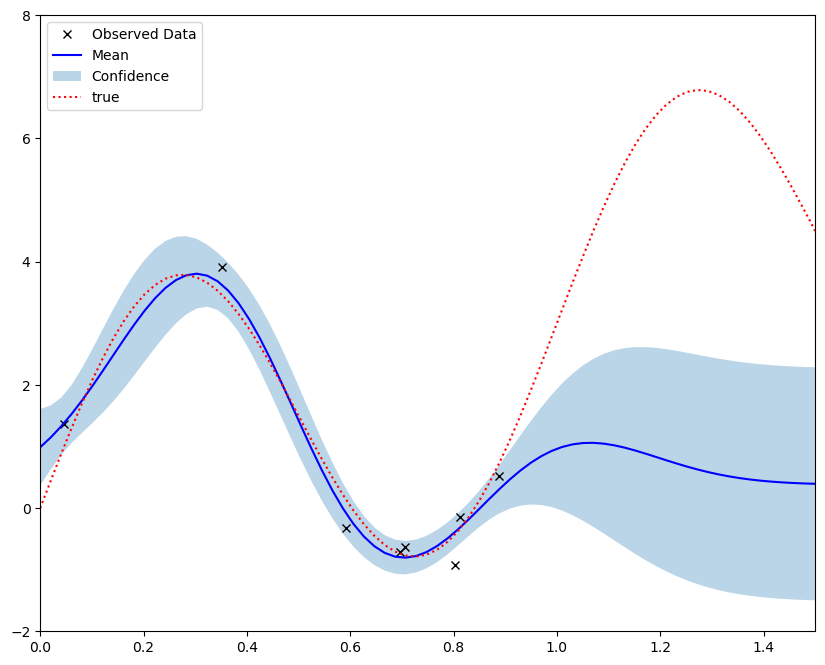

In [15]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
    
# Get upper and lower confidence bounds
lower = (GPf-GPsd)#.flatten()
upper = (GPf+GPsd)#.flatten()

# Plot training data as black stars
ax.plot(train_nx, train_ny, 'kx')
# Plot predictive means as blue line
ax.plot(newx, GPf, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(newx.flatten(),lower.flatten(), upper.flatten(),alpha=0.3)
ax.set_xlim([0,1.5])
ax.set_ylim([-2, 8])
ax.plot(true_x,true_y,linestyle='dotted',color='red')
ax.legend(['Observed Data', 'Mean', 'Confidence','true'])
print ("gpm.kernel.theta",gpm.kernel.theta)
print ("gpm.kernel",gpm.kernel)

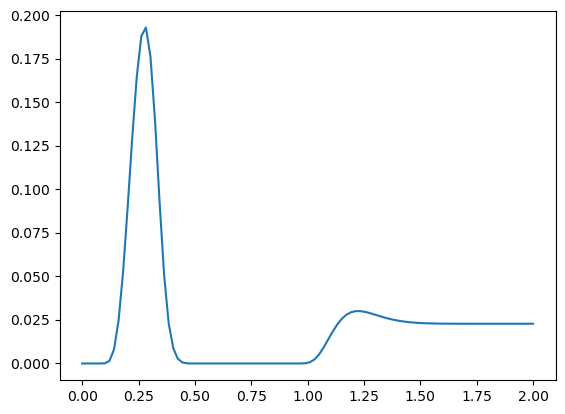

In [26]:
from scipy.stats import norm

current_ymax=np.max(train_ny)
Z = (GPf-current_ymax)/GPsd
ei = ((GPf-current_ymax)*norm.cdf(Z))+(GPsd*norm.pdf(Z))

plt.plot(newx,ei)



<BR> **ここから、論文データを用いたベイズ最適化例**  <BR>
<BR>  データ引用元：　K. Nakano, Y. Noda, N. Tanibata, H. Takeda, M. Nakayama, R. Kobayashi, I. Takeuchi, "Exhaustive and Informatics-Aided Search for Fast Li-Ion Conductor with NASICON-Type Structure Using Material Simulation and Bayesian Optimization", APL Materials,  8, 041112 (2020)　https://doi.org/10.1063/5.0007414
    

In [46]:
path=str("./LCYZP_all.csv")
df_original=pd.read_csv(path, index_col=0)
df = df_original.dropna()
drop_columns = ['EA','s@300','logs@300']
df_descriptor = df.drop(drop_columns, axis=1)
target_columns = ['logs@300']
df_target = df[target_columns]

true_x=df_descriptor.values
true_y=df_target.values

print ("max(y)",np.max(true_y))


max(y) -4.218244625
     Ca   Y        EA         s@300  logs@300
ID                                           
1     0   0  0.400698  6.830000e-06 -5.165579
2     0   4  0.340254  4.220000e-05 -4.374688
3     0   8  0.383561  1.070000e-05 -4.970616
4     0  12  0.366384  2.030000e-05 -4.692504
5     0  16  0.391391  8.310000e-06 -5.080399
..   ..  ..       ...           ...       ...
165  48  32  0.447249  2.070000e-06 -5.684030
166  48  36  0.458762  1.520000e-06 -5.818156
167  48  40  0.469892  1.090000e-06 -5.962574
168  48  44  0.477980  8.130000e-07 -6.089909
169  48  48  0.465419  1.170000e-06 -5.931814

[169 rows x 5 columns]


In [90]:
train_x=np.array([])
train_y=np.array([])
for i in range(6):
    iadd=np.random.randint(len(true_y))
    train_x=np.append(train_x,true_x[iadd,:])
    train_y=np.append(train_y,true_y[iadd,:])
    true_x=np.delete(true_x,iadd,0)
    true_y=np.delete(true_y,iadd,0)

train_x=train_x.reshape(-1,2)
train_y=train_y.reshape(-1,1)

print(train_x)
print(train_y)

[[44. 24.]
 [12.  0.]
 [36. 44.]
 [24. 16.]
 [ 0. 48.]
 [48. 16.]]
[[-5.46852108]
 [-4.50307035]
 [-5.81530857]
 [-5.33913452]
 [-5.69250396]
 [-5.18111459]]


-7.2684891310544195


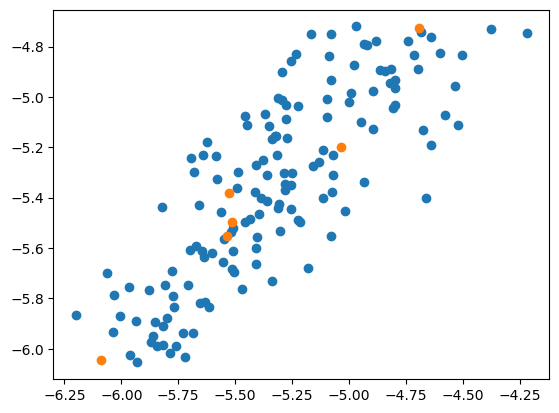

In [84]:
GPf=np.array([])
GPv=np.array([])
Gpsd=np.array([])
GPtry=np.array([])


kk=gp.kernels.ConstantKernel()*gp.kernels.RBF() + gp.kernels.WhiteKernel()
gpm = gp.GaussianProcessRegressor(kernel=kk,alpha=0.1, n_restarts_optimizer=30, normalize_y=True)
gpm.fit(train_x, train_y) 
print(gpm.log_marginal_likelihood())

GPtry, GPtrv = gpm.predict(train_x, return_cov=True)  # 予測値と分散共分散行列

GPf, GPv = gpm.predict(true_x, return_cov=True)  # 予測値と分散共分散行列
GPsd = np.sqrt(np.diag(GPv)).reshape(-1,1)                   # 予測値の標準偏差

plt.scatter(true_y,GPf)
plt.scatter(train_y,GPtry)

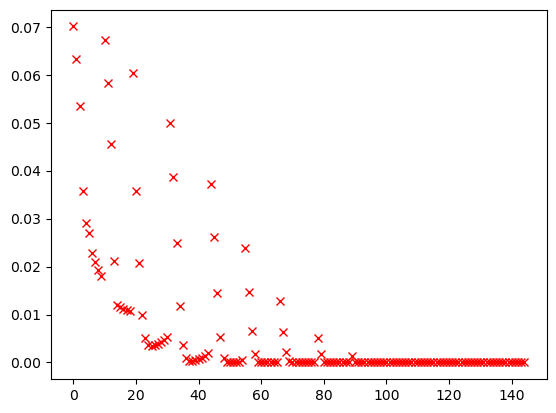

In [85]:
ei=np.array([])
current_ymax=np.max(train_y)
Z = (GPf-current_ymax)/GPsd
ei = ((GPf-current_ymax)*norm.cdf(Z))+(GPsd*norm.pdf(Z))

#print (ei)
plt.plot(ei,"x",color='red')
